In [1]:
import os
import re
import sys
import json
import logging
import collections
import pandas as pd
import numpy as np

from typing import Any, Literal, TypedDict, Callable, cast, TypeVar, Generic

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, average_precision_score
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hc
import scipy.spatial as sp

In [3]:
import time
from typing import Callable, Generic, TypeVar


KT = TypeVar('KT')
VT = TypeVar('VT')


MAX_RETRY = 10
RETRY_WAIT = 0.1


class LRU(Generic[KT, VT]):
    def __init__(
            self,
            max_items: int,
            soft_limit: int | None = None) -> None:
        self._values: dict[KT, VT] = {}
        self._times: dict[KT, float] = {}
        self._max_items = max_items
        self._soft_limit = (
            max(1, int(max_items * 0.9)) if soft_limit is None else soft_limit)
        assert self._max_items >= self._soft_limit

    def get(self, key: KT) -> VT | None:
        res = self._values.get(key)
        if res is not None:
            self._times[key] = time.monotonic()
        return res

    def set(self, key: KT, value: VT) -> None:
        self._values[key] = value
        self._times[key] = time.monotonic()
        self.gc()

    def clear_keys(self, prefix_match: Callable[[KT], bool]) -> None:
        for key in list(self._values.keys()):
            if prefix_match(key):
                self._values.pop(key, None)
                self._times.pop(key, None)

    def gc(self) -> None:
        retry = 0
        while len(self._values) > self._max_items:
            try:
                to_remove = sorted(
                    self._times.copy().items(),
                    key=lambda item: item[1])[:-self._soft_limit]
                for rm_item in to_remove:
                    key = rm_item[0]
                    self._values.pop(key, None)
                    self._times.pop(key, None)
            except RuntimeError:
                # dictionary changed size during iteration: try again
                if retry >= MAX_RETRY:
                    raise
                retry += 1
                if RETRY_WAIT > 0:
                    time.sleep(RETRY_WAIT)

In [4]:
import torch
from torch import nn

def get_device() -> torch.device:
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = get_device()
device

device(type='mps')

In [5]:
from transformers import (
    DistilBertModel,
    DistilBertTokenizer,
    modeling_utils,
    get_scheduler,
)
from torch.optim import AdamW

In [6]:
from tqdm.auto import tqdm
import evaluate
import time

In [7]:
MODEL_FOLDER = "checkpoints"
os.makedirs(MODEL_FOLDER, exist_ok=True)

In [8]:
def batch_dot(batch_a: torch.Tensor, batch_b: torch.Tensor) -> torch.Tensor:
    batch_size = batch_a.shape[0]
    return torch.bmm(
        batch_a.reshape([batch_size, 1, -1]),
        batch_b.reshape([batch_size, -1, 1])).reshape([-1, 1])

In [9]:
TokenizedInput = TypedDict('TokenizedInput', {
    "text": list[str] | None,
    "input_ids": torch.Tensor,
    "attention_mask": torch.Tensor,
})

In [10]:
VERSION = 6
MODEL_BASE = {
    1: "distilbert-base-uncased",
    2: "distilbert-base-uncased",
    3: "distilbert-base-multilingual-cased",
    4: "distilbert-base-multilingual-cased",
    5: "distilbert-base-multilingual-cased",
    6: "distilbert-base-uncased",
}[VERSION]

In [11]:
def get_tokenizer() -> Callable[[list[str], bool], TokenizedInput]:
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_BASE)
    device = get_device()

    def tokens(texts: list[str], preserve_text: bool) -> TokenizedInput:
        res = tokenizer(
            texts, return_tensors="pt", padding=True, truncation=True)
        obj = {k: v.to(device) for k, v in res.items()}
        obj["text"] = texts if preserve_text else None
        return cast(TokenizedInput, obj)

    return tokens

In [12]:
AggType = Literal["cls", "mean"]
AGG_CLS: AggType = "cls"
AGG_MEAN: AggType = "mean"

In [13]:
class TagModel(nn.Module):
    def __init__(
            self,
            *,
            agg: AggType,
            base: str,
            ignore_pretrained_warning: bool = False) -> None:
        super().__init__()
        logger = modeling_utils.logger
        level = logger.getEffectiveLevel()
        try:
            if ignore_pretrained_warning:
                logger.setLevel(logging.ERROR)
            self._bert = DistilBertModel.from_pretrained(base)
        finally:
            if ignore_pretrained_warning:
                logger.setLevel(level)
        self._agg = agg
        self._test_lru = None
        
        def cache_hook(*args: Any, **kwargs: Any) -> None:
            self.clear_cache()
        
        self.register_load_state_dict_post_hook(cache_hook)
        self.register_state_dict_pre_hook(cache_hook)

    def _get_agg(self, lhs: torch.Tensor) -> torch.Tensor:
        if self._agg == AGG_CLS:
            return lhs[:, 0]
        if self._agg == AGG_MEAN:
            return torch.mean(lhs, dim=1)
        raise ValueError(f"unknown aggregation: {self._agg}")

    def _embed(
            self,
            input_ids: torch.Tensor,
            attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self._bert(
            input_ids=input_ids, attention_mask=attention_mask)
        out = self._get_agg(outputs.last_hidden_state)
        return out
    
    def clear_cache(self) -> None:
        self._test_lru = None

    def forward(
            self,
            x: TokenizedInput) -> torch.Tensor:
        if self.training and self._test_lru is not None:
            self.clear_cache()
        if not self.training:
            if self._test_lru is None:
                self._test_lru = LRU(1000)
            if x["text"] is not None:
                res = []
                for row_ix, text in enumerate(x["text"]):
                    cache_res = self._test_lru.get(text)
                    if cache_res is None:
                        cache_res = self._embed(
                            input_ids=x["input_ids"][[row_ix]],
                            attention_mask=x["attention_mask"][[row_ix]]).detach()
                        self._test_lru.set(text, cache_res)
                    res.append(torch.clone(cache_res))
                return torch.vstack(res)
        return self._embed(
            input_ids=x["input_ids"],
            attention_mask=x["attention_mask"])


class TrainingHarness(nn.Module):
    def __init__(self, model: TagModel, model_right: TagModel | None, use_cos: bool) -> None:
        super().__init__()
        self._model_left = model
        self._model_right = model if model_right is None else model_right
        self._loss = nn.BCELoss()
        self._cos = nn.CosineSimilarity() if use_cos else None
        
    def _combine(self, left_embed: torch.Tensor, right_embed: torch.Tensor) -> torch.Tensor:
        if self._cos is None:
            # NOTE: torch.sigmoid would be a bad idea here
            return batch_dot(left_embed, right_embed)
        return self._cos(left_embed, right_embed).reshape([-1, 1])
    
    def get_model_left(self) -> TagModel:
        return self._model_left
    
    def get_model_right(self) -> TagModel:
        return self._model_right

    def forward(
            self,
            *,
            left: TokenizedInput,
            right: TokenizedInput,
            labels: torch.Tensor | None = None,
            force_left_model: bool | None = None) -> tuple[torch.Tensor, torch.Tensor] | torch.Tensor:
        left_embed = self._model_right(left) if force_left_model is False else self._model_left(left)
        right_embed = self._model_left(right) if force_left_model is True else self._model_right(right)
        preds = self._combine(left_embed, right_embed)
        if labels is None:
            return preds
        probs = torch.hstack([1.0 - preds, preds])
        return preds, self._loss(probs, labels)

In [14]:
tokens = get_tokenizer()

In [15]:
def create_model(config) -> TagModel:
    return TagModel(agg=config["agg"], base=config["base"], ignore_pretrained_warning=True)


def load_model(harness, model_fname):
    print(f"loading {model_fname}")
    with open(model_fname, "rb") as fin:
        harness.load_state_dict(torch.load(fin, map_location=device))


def compute(harness, df, *, preserve_text):
    lefts = tokens(df["left"].tolist(), preserve_text)
    rights = tokens(df["right"].tolist(), preserve_text)
    labels = torch.tensor(
        np.array([~df["is_correct"], df["is_correct"]]),
        dtype=torch.float32).T.to(device)
   
    preds, loss = harness(
        left=lefts,
        right=rights,
        labels=labels)
    return preds, loss


def run_training(*, prefix, num_epochs, train_size, train_df_gen, test_df, config, resume, skip_test):
    model_left = create_model(config)
    model_left.to(device)
    if config["one_embedding"]:
        model_right = None
    else:
        model_right = create_model(config)
        model_right.to(device)
    harness = TrainingHarness(model_left, model_right, use_cos=config["use_cos"])
    harness.to(device)

    try:
        batch_size_train = 3
        batch_size_test = 12
        est_th = 0.5
        optimizer = AdamW(harness.parameters(), lr=5e-5)

        num_training_steps = num_epochs * train_size // batch_size_train
        warmup = 1000
        lr_scheduler = get_scheduler(
            name="linear",
            optimizer=optimizer,
            num_warmup_steps=warmup,
            num_training_steps=num_training_steps - warmup)

        for epoch in range(num_epochs):
            print(f"epoch {epoch} train size {train_size} test size {test_df.shape[0]}")
            real_time = time.monotonic()

            model_fname = os.path.join(MODEL_FOLDER, f"{prefix}_model_{epoch}.pkl")
            stats_fname = os.path.join(MODEL_FOLDER, f"{prefix}_stats_{epoch}.json")

            acc_train = evaluate.load("accuracy")
            pre_train = evaluate.load("precision")
            rec_train = evaluate.load("recall")
            train_loss = []

            cur_skip_test = skip_test
            if os.path.exists(model_fname) or os.path.exists(stats_fname):
                if os.path.exists(model_fname):
                    load_model(harness, model_fname)
                else:
                    print("WARNING: stats file detected but no model file. not loading model", file=sys.stderr)
                train_loss.append(0)
                acc_train.add_batch(
                    predictions=[0, 1],
                    references=[0, 1])
                pre_train.add_batch(
                    predictions=[0, 1],
                    references=[0, 1])
                rec_train.add_batch(
                    predictions=[0, 1],
                    references=[0, 1])
            else:
                train_df = train_df_gen(config, train_size)
                model_left = harness.get_model_left()
                model_left.train()
                model_right = harness.get_model_right()
                model_right.train()
                harness.train()
                with tqdm(desc="train", total=train_df.shape[0]) as progress_bar:
                    for train_chunk in np.array_split(train_df, np.ceil(train_df.shape[0] / batch_size_train)):
                        preds, loss = compute(harness, train_chunk, preserve_text=False)
                        train_loss.append(loss.item())
                        loss.backward()

                        optimizer.step()
                        lr_scheduler.step()
                        optimizer.zero_grad()
                        progress_bar.update(train_chunk.shape[0])

                        labels = train_chunk["is_correct"].astype(int).to_numpy()
                        predictions = (preds > est_th).to(int)
                        acc_train.add_batch(
                            predictions=predictions,
                            references=labels)
                        pre_train.add_batch(
                            predictions=predictions,
                            references=labels)
                        rec_train.add_batch(
                            predictions=predictions,
                            references=labels)

                torch.save(harness.state_dict(), model_fname)
                cur_skip_test = False

            if not cur_skip_test:
                acc_test = evaluate.load("accuracy")
                pre_test = evaluate.load("precision")
                rec_test = evaluate.load("recall")
                test_loss = []

                model_left = harness.get_model_left()
                model_left.eval()
                model_right = harness.get_model_right()
                model_right.eval()
                harness.eval()
                with torch.no_grad():
                    with tqdm(desc="test", total=test_df.shape[0]) as progress_bar:
                        for test_chunk in np.array_split(test_df, np.ceil(test_df.shape[0] / batch_size_test)):
                            preds, loss = compute(harness, test_chunk, preserve_text=True)
                            test_loss.append(loss.item())

                            progress_bar.update(test_chunk.shape[0])
                            
                            labels = test_chunk["is_correct"].astype(int).to_numpy()
                            predictions = (preds > est_th).to(int)
                            acc_test.add_batch(
                                predictions=predictions,
                                references=labels)
                            pre_test.add_batch(
                                predictions=predictions,
                                references=labels)
                            rec_test.add_batch(
                                predictions=predictions,
                                references=labels)

                stats = {
                    "epoch": int(epoch),
                    "train_acc": float(acc_train.compute()["accuracy"]),
                    "train_pre": float(pre_train.compute()["precision"]),
                    "train_rec": float(rec_train.compute()["recall"]),
                    "train_loss": float(np.mean(train_loss)),
                    "test_acc": float(acc_test.compute()["accuracy"]),
                    "test_pre": float(pre_test.compute()["precision"]),
                    "test_rec": float(rec_test.compute()["recall"]),
                    "test_loss": float(np.mean(test_loss)),
                    "time": 0.0,
                    "config": config,
                    "version": VERSION,
                }

                print(
                    f"train[acc: {stats['train_acc']} "
                    f"pre: {stats['train_pre']} "
                    f"rec: {stats['train_rec']} "
                    f"loss: {stats['train_loss']}]")
                print(
                    f"test[acc: {stats['test_acc']} "
                    f"pre: {stats['test_pre']} "
                    f"rec: {stats['test_rec']} "
                    f"loss: {stats['test_loss']}]")
                stats["time"] = float((time.monotonic() - real_time) / 60.0)
                print(f"epoch time: {stats['time']:.2f}min")

                with open(stats_fname, "w") as fout:
                    print(json.dumps(stats, indent=4, sort_keys=True), file=fout)
    
    except KeyboardInterrupt:
        print("TERMINATED BY USER", file=sys.stderr)
    return harness

In [16]:
DF = pd.read_parquet("traintest.pq")
DF

,stage,id,db,country,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,tag_Bicicleta,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
0,validation,5019,sm,GIN,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,validation,5164,sm,GIN,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,test,5022,sm,GIN,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,train,2783,sm,GIN,Public Lights auto managed,Public Lights auto managed \nSolution developp...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,test,5021,sm,GIN,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4248,validation,197,exp,LBY,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4249,validation,362,exp,GTM,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4250,validation,252,exp,PHL,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4251,validation,241,exp,PHL,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
FULL_TRAIN = DF[DF["stage"] == "train"]
FULL_TEST = DF[DF["stage"] == "test"]
FULL_REST = DF[(DF["stage"] != "train") & (DF["stage"] != "test")]
display(FULL_TRAIN)
display(FULL_TEST)
FULL_TRAIN.shape, FULL_TEST.shape, FULL_REST.shape

,stage,id,db,country,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,tag_Bicicleta,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
3,train,2783,sm,GIN,Public Lights auto managed,Public Lights auto managed \nSolution developp...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,train,4466,sm,MKD,"Certificates (birth, marriage): request and de...","Certificates (birth, marriage): request and de...",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,train,5367,sm,SWZ,Ndinda Gully Rehabilitation Project,Ndinda Gully Rehabilitation Project \nSmallhol...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,train,4357,sm,ETH,Improved cook stove,Improved cook stove\nSileshi Abebe Alemayehu ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,train,5275,sm,PAN,[Reciclaje] Compra y Venta Raschell,[Reciclaje] Compra y Venta Raschell\nCONTACTO ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,train,5954,sm,SYR,A Syria geography teacher innovates a new mach...,A Syria geography teacher innovates a new mach...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3177,train,5295,sm,MRT,PYROLYSE DE PLASTIQUE (PDP),PYROLYSE DE PLASTIQUE (PDP) \nFatma SAGHIR...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3178,train,5782,sm,ARG,Citizen science on monitoring and mapping of t...,Citizen science on monitoring and mapping of t...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3180,train,5965,sm,ARG,Citizen Science on monitoring of invasive alie...,Citizen Science on monitoring of invasive alie...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


,stage,id,db,country,title,text,tag_3d printing,tag_Acupuntura Urbana,tag_Bebidas Tradicionales,tag_Bicicleta,...,tag_wood gas,tag_wood stove,tag_woodchips,tag_worker safety,tag_youth,tag_youth activism,tag_youth and unemployment,tag_youth empowerment,tag_youth informality,tag_zero waste
2,test,5022,sm,GIN,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,test,5021,sm,GIN,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8,test,4364,sm,ETH,Tikikil stove,Tikikil stove\nGIZ\nOffice contact GIZ Office ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,test,5777,sm,ETH,Green Tech Packaging Solutions,Green Tech Packaging Solutions \nDesign and de...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19,test,5827,sm,IRQ,Origins: Personal Incubator,Origins: Personal Incubator\nWhat is Origins?\...,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,test,5759,sm,NER,Smart O' ou jardin smart,Smart O' ou jardin smart\n\n\n&nbsp; &nbsp; &n...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3167,test,5608,sm,NER,Kizha Intregrate farm_Race Taureau,Kizha Intregrate farm_Race Taureau\n\n\nkizha ...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3169,test,4690,sm,BGD,Safepad - sustainable sanitary napkin,Safepad - sustainable sanitary napkin\n\n\nSaf...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3173,test,4362,sm,ETH,Cow dung beehive briquette,Cow dung beehive briquette \n\n\nAstmamgn Amar...,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


((1000, 889), (1000, 889), (2253, 889))

In [18]:
RNG = np.random.default_rng(42)

In [19]:
TAG_PREFIX = "tag_"
TAG_COLS = [col for col in DF.columns if col.startswith(TAG_PREFIX)]
TAGS = [col[len(TAG_PREFIX):] for col in TAG_COLS]

def get_tags(df: pd.DataFrame, ix: int) -> list[str]:
    cur = df.iloc[ix][TAG_COLS]
    return sorted(col[len(TAG_PREFIX):] for col in cur[cur].index)

TAGS[:10]

['3d printing',
 'Acupuntura Urbana',
 'Bebidas Tradicionales',
 'Bicicleta',
 'Bicycle',
 'Cadenas de Valor',
 'Coca',
 'Conectividad',
 'Construction',
 'Contactlessness']

In [20]:
def clean(text: str) -> str:
    return re.sub("[ \t]+", " ", re.sub("\n[ \t]+", "\n", re.sub("\n\n+", "\n", re.sub("\r", "\n", text.strip()))))

def build_df(full_df: pd.DataFrame, num_rows: int | None, *, prob_correct: float = 0.5) -> pd.DataFrame:
    df_builder = {
        "left": [],
        "right": [],
        "is_correct": [],
    }
    if num_rows is None:
        ixs = list(range(full_df.shape[0]))
    else:
        ixs = RNG.choice(list(range(full_df.shape[0])), num_rows, replace=True)
    for row_ix in ixs:
        cur_row = full_df.iloc[row_ix]
        cur_text = clean(f"{cur_row['title']}:\n{cur_row['text']}")
        cur_tags = get_tags(full_df, row_ix)
        if num_rows is None:
            for tag in TAGS:
                df_builder["right"].append(cur_text)
                df_builder["left"].append(tag)
                df_builder["is_correct"].append(bool(cur_row[f"{TAG_PREFIX}{tag}"]))
        else:
            df_builder["right"].append(cur_text)
            if cur_tags and RNG.random() < prob_correct:
                df_builder["left"].append(RNG.choice(cur_tags, 1)[0])
                df_builder["is_correct"].append(True)
            else:
                tag = RNG.choice(TAGS, 1)[0]
                df_builder["left"].append(tag)
                df_builder["is_correct"].append(bool(cur_row[f"{TAG_PREFIX}{tag}"]))
    return pd.DataFrame(df_builder, columns=["left", "right", "is_correct"])

In [21]:
TEST_DF = build_df(FULL_TEST, None).groupby("is_correct", group_keys=False).apply(lambda x: x.sample(min(x.shape[0], 7000)))
TEST_DF = TEST_DF.sort_values("right")
TEST_DF

,left,right,is_correct
595947,transfer of knowledge and technology,"""Ai Nono"" - Traditional practice of construct...",True
595961,urban development,"""Ai Nono"" - Traditional practice of construct...",False
595491,environmental justice,"""Ai Nono"" - Traditional practice of construct...",False
595682,natural solutions,"""Ai Nono"" - Traditional practice of construct...",False
595308,co creation,"""Ai Nono"" - Traditional practice of construct...",False
...,...,...,...
787630,youth,“Books on the Road”:\n“Books on the Road”\nMee...,True
786780,Library,“Books on the Road”:\n“Books on the Road”\nMee...,True
786930,commons,“Books on the Road”:\n“Books on the Road”\nMee...,True
786980,culture,“Books on the Road”:\n“Books on the Road”\nMee...,True


In [22]:
harness = run_training(
    prefix=f"v{VERSION}",
    num_epochs=6,
    train_size=12000,
    train_df_gen=lambda config, size: build_df(FULL_TRAIN, size, prob_correct=config["proc_correct"]),
    test_df=TEST_DF,
    config={
        "agg": "cls",
        "use_cos": True,
        "proc_correct": 0.6,
        "base": MODEL_BASE,
        "one_embedding": False,
    },
    resume=True,
    skip_test=True)

epoch 0 train size 12000 test size 10000


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train[acc: 0.411 pre: 0.9444444444444444 rec: 0.0023997741389045735 loss: 0.6780694332048297]
test[acc: 0.7 pre: 0.0 rec: 0.0 loss: 0.7753399442926013]
epoch time: 75.54min
epoch 1 train size 12000 test size 10000


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train[acc: 0.4035 pre: 0.0 rec: 0.0 loss: 0.7730178220272064]
test[acc: 0.7 pre: 0.0 rec: 0.0 loss: 0.5887430955608972]
epoch time: 90.83min
epoch 2 train size 12000 test size 10000


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train[acc: 0.40075 pre: 0.0 rec: 0.0 loss: 0.7004957835376263]
test[acc: 0.7 pre: 0.0 rec: 0.0 loss: 0.5887144245117975]
epoch time: 91.09min
epoch 3 train size 12000 test size 10000


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train[acc: 0.3953333333333333 pre: 0.0 rec: 0.0 loss: 0.6344093728587031]
test[acc: 0.7 pre: 0.0 rec: 0.0 loss: 0.6002973159797472]
epoch time: 84.76min
epoch 4 train size 12000 test size 10000


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train[acc: 0.39708333333333334 pre: 0.0 rec: 0.0 loss: 0.6021544197127223]
test[acc: 0.7 pre: 0.0 rec: 0.0 loss: 0.6155827337746426]
epoch time: 77.70min
epoch 5 train size 12000 test size 10000


train:   0%|          | 0/12000 [00:00<?, ?it/s]

test:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train[acc: 0.39616666666666667 pre: 0.0 rec: 0.0 loss: 0.5838822128027678]
test[acc: 0.7 pre: 0.0 rec: 0.0 loss: 0.6240340696750499]
epoch time: 85.39min


In [23]:
def compute_tag_matrix(harness: TrainingHarness) -> pd.DataFrame:
    plan = []
    for lix, left in enumerate(TAGS):
        for rix, right in enumerate(TAGS):
            if lix > rix:
                continue
            plan.append((lix, rix, left, right))
    
    res = np.zeros((len(TAGS), len(TAGS)))
    batch_size = 16
    model = harness.get_model_left()
    model.eval()
    with torch.no_grad():
        with tqdm(desc="tags", total=len(plan)) as progress_bar:
            for chunk in np.array_split(plan, np.ceil(len(plan) / batch_size)):
                lixs, rixs, left_strs, right_strs = tuple(zip(*chunk))
                lefts = tokens(left_strs, True)
                rights = tokens(right_strs, True)   
                preds = harness(
                    left=lefts,
                    right=rights,
                    force_left_model=True)
                for lix, rix, val in zip(lixs, rixs, preds.ravel().tolist()):
                    res[int(lix), int(rix)] = val
                    res[int(rix), int(lix)] = val
                progress_bar.update(chunk.shape[0])
    return pd.DataFrame(res, columns=TAGS, index=TAGS)

In [24]:
TAG_FILE = f"tags_{VERSION}.pq"
if os.path.exists(TAG_FILE):
    tag_matrix = pd.read_parquet(TAG_FILE)
else:
    tag_matrix = compute_tag_matrix(harness)
    tag_matrix.to_parquet(TAG_FILE)
tag_matrix

tags:   0%|          | 0/390286 [00:00<?, ?it/s]

,3d printing,Acupuntura Urbana,Bebidas Tradicionales,Bicicleta,Bicycle,Cadenas de Valor,Coca,Conectividad,Construction,Contactlessness,...,wood gas,wood stove,woodchips,worker safety,youth,youth activism,youth and unemployment,youth empowerment,youth informality,zero waste
3d printing,1.000000,0.952563,0.980722,0.924250,0.963218,0.946789,0.935956,0.938671,0.962307,0.978735,...,0.947654,0.946879,0.940402,0.963706,0.941689,0.972288,0.769301,0.852030,0.941475,0.882991
Acupuntura Urbana,0.952563,1.000000,0.965462,0.991685,0.987389,0.897803,0.994306,0.995394,0.990125,0.950757,...,0.992775,0.996384,0.994155,0.991565,0.870701,0.985785,0.615175,0.720974,0.874299,0.759652
Bebidas Tradicionales,0.980722,0.965462,1.000000,0.939120,0.972981,0.958042,0.950631,0.952734,0.969505,0.981650,...,0.958844,0.958923,0.953670,0.975705,0.935242,0.979422,0.757910,0.842018,0.936566,0.869450
Bicicleta,0.924250,0.991685,0.939120,1.000000,0.980747,0.854850,0.997591,0.997070,0.979725,0.918912,...,0.991675,0.995544,0.994617,0.982462,0.825047,0.971088,0.538439,0.651241,0.826701,0.696027
Bicycle,0.963218,0.987389,0.972981,0.980747,1.000000,0.908752,0.983034,0.982186,0.986827,0.958204,...,0.984017,0.984969,0.983347,0.988133,0.894858,0.985213,0.655974,0.755064,0.893351,0.791122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youth activism,0.972288,0.985785,0.979422,0.971088,0.985213,0.929163,0.976965,0.981096,0.986252,0.974342,...,0.981368,0.983889,0.980022,0.990807,0.929054,1.000000,0.705798,0.799915,0.926083,0.824534
youth and unemployment,0.769301,0.615175,0.757910,0.538439,0.655974,0.825599,0.564055,0.576242,0.654432,0.793584,...,0.596010,0.593266,0.579594,0.658212,0.893916,0.705798,1.000000,0.967263,0.881765,0.942541
youth empowerment,0.852030,0.720974,0.842018,0.651241,0.755064,0.887208,0.673578,0.684632,0.754187,0.869542,...,0.701543,0.700621,0.689912,0.758178,0.948918,0.799915,0.967263,1.000000,0.933693,0.956262
youth informality,0.941475,0.874299,0.936566,0.826701,0.893351,0.934916,0.843622,0.850303,0.895712,0.952354,...,0.857835,0.860030,0.853419,0.898553,0.983054,0.926083,0.881765,0.933693,1.000000,0.927442


In [25]:
(1.0 - tag_matrix.to_numpy()).round(6)

array([[0.      , 0.047437, 0.019278, ..., 0.14797 , 0.058525, 0.117009],
       [0.047437, 0.      , 0.034538, ..., 0.279026, 0.125701, 0.240348],
       [0.019278, 0.034538, 0.      , ..., 0.157982, 0.063434, 0.13055 ],
       ...,
       [0.14797 , 0.279026, 0.157982, ..., 0.      , 0.066307, 0.043738],
       [0.058525, 0.125701, 0.063434, ..., 0.066307, 0.      , 0.072558],
       [0.117009, 0.240348, 0.13055 , ..., 0.043738, 0.072558, 0.      ]])

In [26]:
tag_linkage = hc.linkage(sp.distance.squareform((1.0 - tag_matrix.to_numpy()).round(6)), method="average")

In [27]:
sns.clustermap(
    tag_matrix,
    row_linkage=tag_linkage,
    col_linkage=tag_linkage,
    cmap="OrRd",
    figsize=(300, 300),
    linewidth=0)
plt.savefig(f"dendrogram_large_{VERSION}.png", bbox_inches="tight")
plt.close()

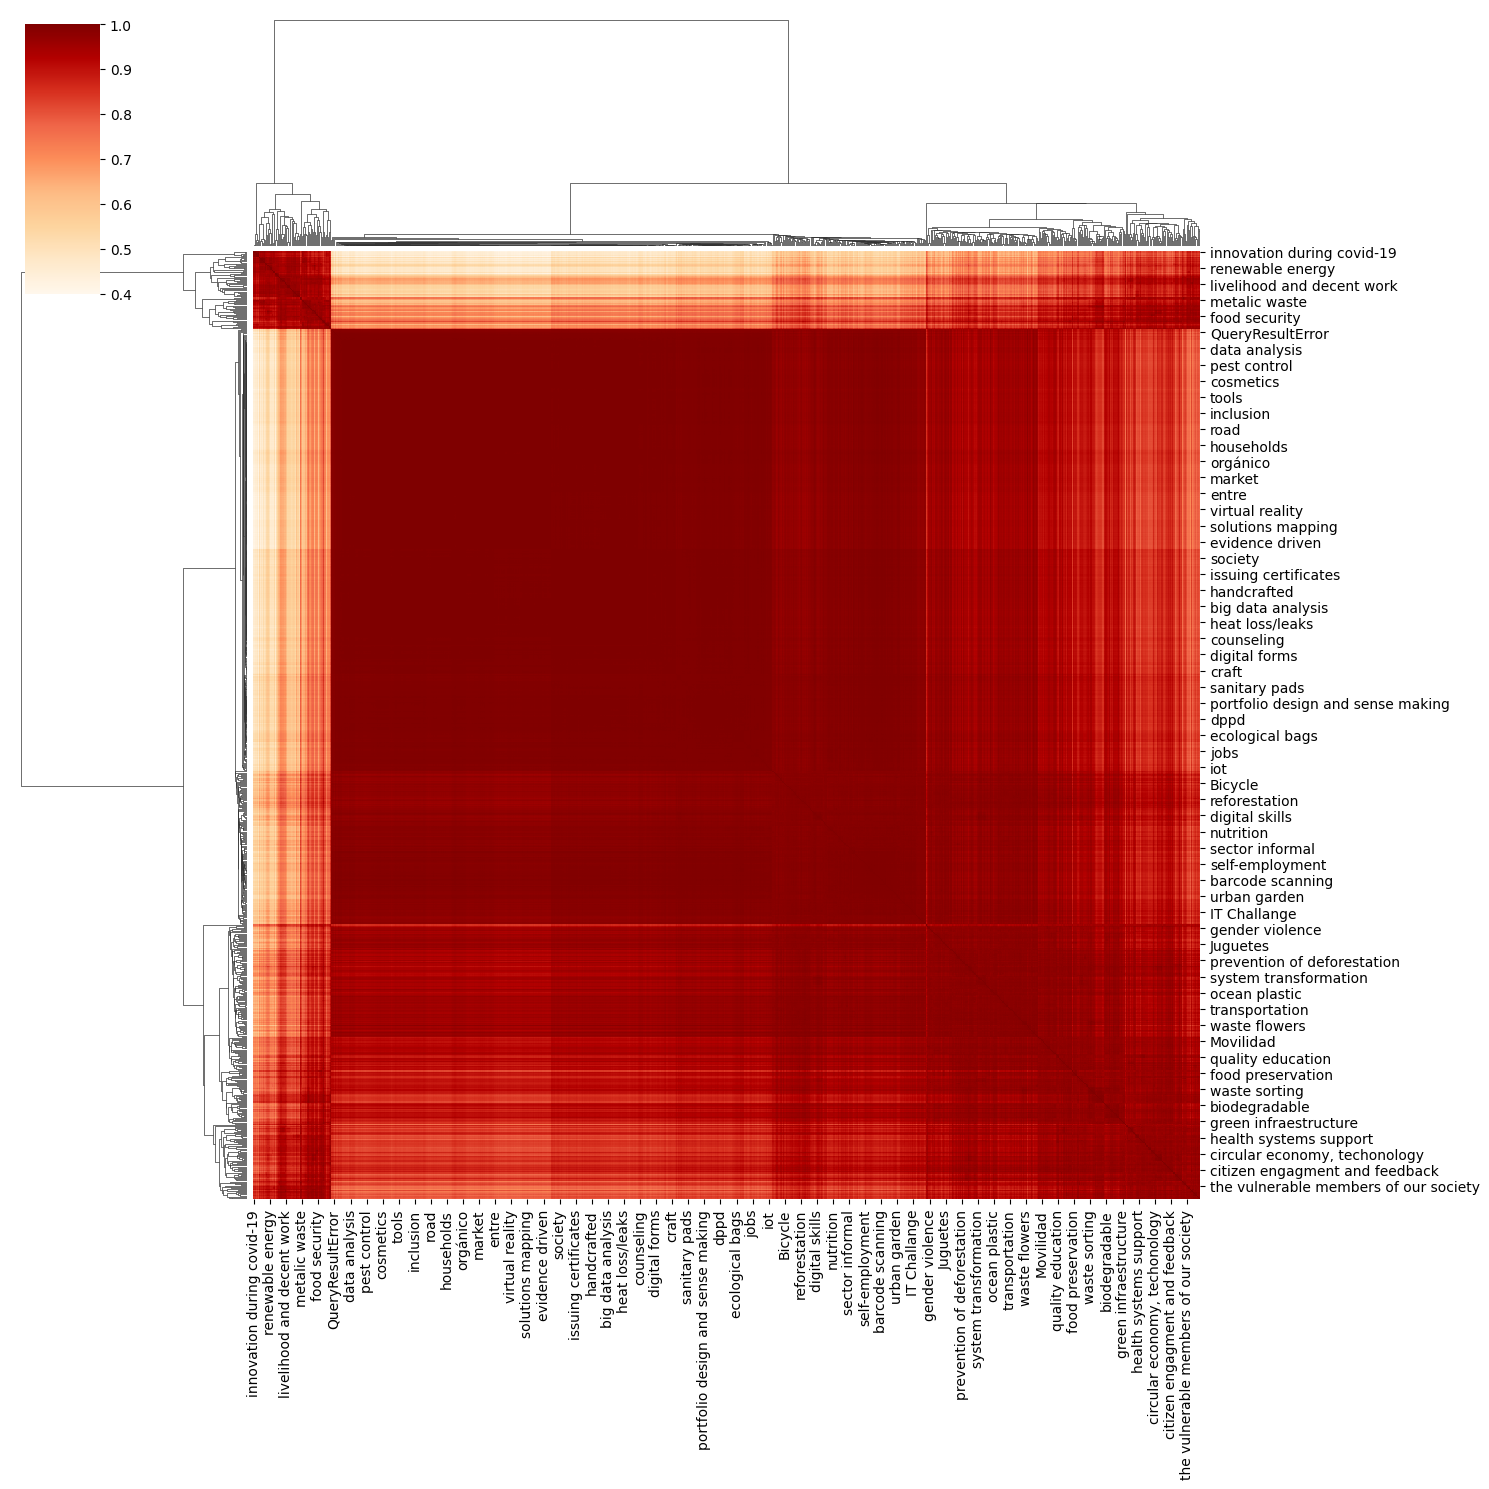

In [28]:
sns.clustermap(
    tag_matrix,
    row_linkage=tag_linkage,
    col_linkage=tag_linkage,
    cmap="OrRd",
    figsize=(15, 15),
    linewidth=0)
plt.savefig(f"dendrogram_{VERSION}.png", bbox_inches="tight")

In [29]:
len(TAGS)

883

In [30]:
def get_preds(df: pd.DataFrame, harness: TrainingHarness) -> pd.DataFrame:
    batch_size = 16
    model_left = harness.get_model_left()
    model_left.eval()
    model_right = harness.get_model_right()
    model_right.eval()
    harness.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        with tqdm(desc="data", total=df.shape[0]) as progress_bar:
            for chunk in np.array_split(df, np.ceil(df.shape[0] / batch_size)):
                preds, _ = compute(harness, chunk, preserve_text=True)

                progress_bar.update(chunk.shape[0])
                all_preds.extend(preds.ravel().tolist())
                all_labels.extend(chunk["is_correct"].astype(int).to_list())
    return pd.DataFrame({"preds": all_preds, "labels": all_labels}, columns=["preds", "labels"])

In [31]:
preds = get_preds(TEST_DF, harness)
preds

data:   0%|          | 0/10000 [00:00<?, ?it/s]

,preds,labels
0,0.548553,1
1,0.466732,0
2,0.454908,0
3,0.374015,0
4,0.371145,0
...,...,...
9995,0.655964,1
9996,0.359153,1
9997,0.488997,1
9998,0.505330,1


In [32]:
preds["labels"].astype(bool).describe()

count     10000
unique        2
top       False
freq       7000
Name: labels, dtype: object

/var/folders/ff/zrdw3xx56dd1w9xbl6x_yl0c0000gn/T/ipykernel_65168/4107809916.py:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)


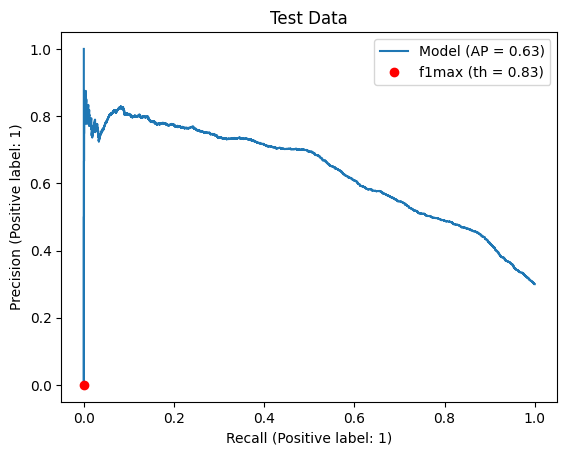

In [33]:
precision, recall, thresholds = precision_recall_curve(preds["labels"], preds["preds"], pos_label=1)
f1_scores = 2 * recall * precision / (recall + precision)
best_th_ix = np.argmax(f1_scores)
best_thresh = thresholds[best_th_ix]
average_precision = average_precision_score(preds["labels"], preds["preds"], pos_label=1)
display = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=average_precision,
    estimator_name="Model",
    pos_label=1)
display.plot(name="Model")
display.ax_.set_title("Test Data")
display.ax_.plot(recall[best_th_ix], precision[best_th_ix], "ro", label=f"f1max (th = {best_thresh:.2f})")
display.ax_.legend()
None

In [34]:
def add_embeds(
        df: pd.DataFrame,
        harness: TrainingHarness,
        name: str,
        embeds: list[np.ndarray],
        names: list[str],
        *,
        is_right: bool) -> None:
    batch_size = 8
    model = harness.get_model_right() if is_right else harness.get_model_left()
    model.eval()
    with torch.no_grad():
        with tqdm(desc=name, total=df.shape[0]) as progress_bar:
            for chunk in np.array_split(df, np.ceil(df.shape[0] / batch_size)):
                embed = model(tokens([clean(txt) for txt in chunk["text"].tolist()], False))
                embeds.append(embed.numpy(force=True))
                names.extend([f"{'r' if is_right else 'l'}_{name}"] * chunk.shape[0])
                
                progress_bar.update(chunk.shape[0])

In [35]:
def get_all_embeds(harness: TrainingHarness) -> tuple[np.ndarray, list[str]]:
    embeds = []
    names = []
    add_embeds(pd.DataFrame({"text": FULL_REST["title"].astype(str)}), harness, "title", embeds, names, is_right=False)
    add_embeds(
        pd.DataFrame({"text": FULL_REST["title"].astype(str) + ":\n" + FULL_REST["text"].astype(str)}),
        harness,
        "full",
        embeds,
        names,
        is_right=True)
    add_embeds(pd.DataFrame({"text": TAGS}), harness, "tags", embeds, names, is_right=False)
    return np.vstack(embeds), names

In [36]:
ALL_EMBEDS, ALL_NAMES = get_all_embeds(harness)
ALL_EMBEDS.shape[0], len(ALL_NAMES)

title:   0%|          | 0/2253 [00:00<?, ?it/s]

full:   0%|          | 0/2253 [00:00<?, ?it/s]

tags:   0%|          | 0/883 [00:00<?, ?it/s]

(5389, 5389)

In [37]:
CMAP = {
    "l_title": "tab:blue",
    "l_tags": "tab:orange",
    "r_full": "tab:green",
}

In [38]:
EMBED_FILE = f"embeds_{VERSION}.pq"
if os.path.exists(EMBED_FILE):
    ALL_EMBED_DF = pd.read_parquet(EMBED_FILE)
else:
    ALL_TSNE_EMBEDS = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric="cosine",
        n_jobs=-1).fit_transform(ALL_EMBEDS)
    ALL_EMBED_DF = pd.DataFrame({
        "x": ALL_TSNE_EMBEDS[:, 0],
        "y": ALL_TSNE_EMBEDS[:, 1],
        "l": [CMAP[name] for name in ALL_NAMES],
        "cat": ALL_NAMES})
    ALL_EMBED_DF.to_parquet(EMBED_FILE)
ALL_EMBED_DF

,x,y,l,cat
0,13.628338,26.508404,tab:blue,l_title
1,-42.781895,28.925703,tab:blue,l_title
2,-24.227949,40.044281,tab:blue,l_title
3,23.265108,14.190881,tab:blue,l_title
4,22.363966,14.537026,tab:blue,l_title
...,...,...,...,...
5384,8.002876,21.990910,tab:orange,l_tags
5385,68.833038,3.060256,tab:orange,l_tags
5386,67.993568,4.445570,tab:orange,l_tags
5387,62.896011,16.351059,tab:orange,l_tags


<AxesSubplot: xlabel='x', ylabel='y'>

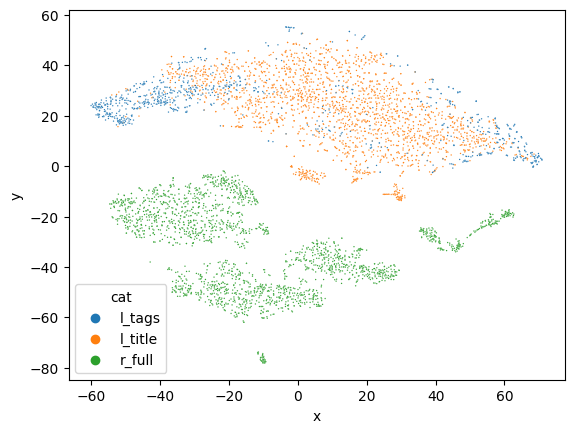

In [39]:
sns.scatterplot(
    data=ALL_EMBED_DF,
    x="x",
    y="y",
    s=1.0,
    hue="cat",
    hue_order=["l_tags", "l_title", "r_full"])

In [40]:
def scatter_embed(all_embeds, all_names, filter_name):
    tsne_embed = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric="cosine",
        n_jobs=-1).fit_transform(
            all_embeds[[
                ix
                for ix, name in enumerate(all_names)
                if name == filter_name
            ], :])
    embed_df = pd.DataFrame({
        "x": tsne_embed[:, 0],
        "y": tsne_embed[:, 1]})
    sns.scatterplot(
        data=embed_df,
        x="x",
        y="y",
        s=4.0).set(title=filter_name)

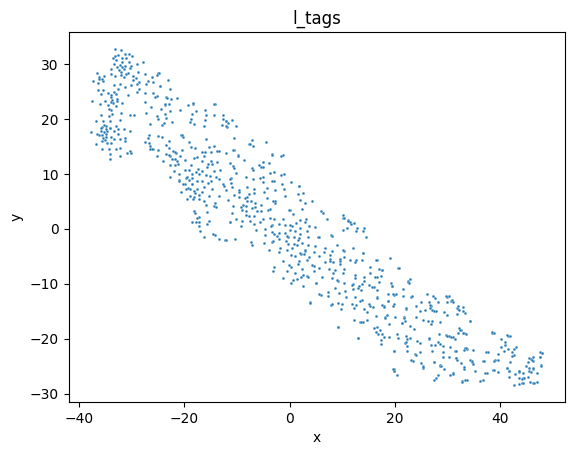

In [41]:
scatter_embed(ALL_EMBEDS, ALL_NAMES, "l_tags")

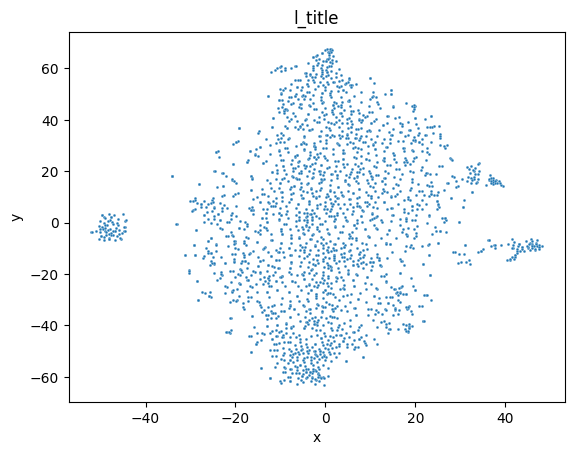

In [42]:
scatter_embed(ALL_EMBEDS, ALL_NAMES, "l_title")

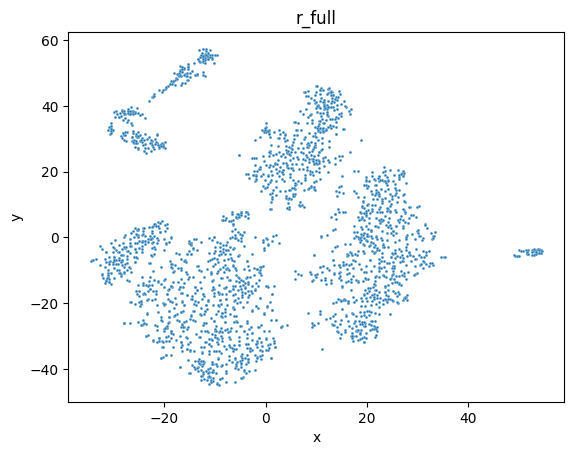

In [43]:
scatter_embed(ALL_EMBEDS, ALL_NAMES, "r_full")

In [44]:
#  Using the embeddings
# ======================

# 1. remove (clusters of) duplicate tags
# 2. suggest tags for a given title or title + text
# 3. allow to add new tags and suggest documents which might also fit that tag
# 4. prompt for searching related documents

In [45]:
def add_db(x: pd.DataFrame) -> pd.DataFrame:
    embeds = []
    add_embeds(pd.DataFrame({"text": x["text"].astype(str)}), harness, "", embeds, [], is_right=True)
    all_embeds = np.vstack(embeds)
    x = x[[col for col in x.columns if not col.startswith(TAG_PREFIX) and col != "stage"]]
    x["embedding"] = all_embeds.tolist()
    return x

LOOKUP_DF = DF.groupby("db", group_keys=False).apply(add_db)
LOOKUP_DF

  0%|          | 0/862 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/3189 [00:00<?, ?it/s]

,id,db,country,title,text,embedding
0,5019,sm,GIN,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,"[-0.03254999965429306, -0.4044889807701111, 0...."
1,5164,sm,GIN,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,"[-0.0732727125287056, -0.43416595458984375, 0...."
2,5022,sm,GIN,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,"[-0.09812592715024948, -0.25181931257247925, -..."
3,2783,sm,GIN,Public Lights auto managed,Public Lights auto managed \nSolution developp...,"[-0.0893172100186348, -0.425068199634552, 0.16..."
4,5021,sm,GIN,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,"[-0.095884770154953, -0.19237294793128967, -0...."
...,...,...,...,...,...,...
4248,197,exp,LBY,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,"[-0.055976662784814835, -0.4443334937095642, 0..."
4249,362,exp,GTM,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,"[-0.09873020648956299, -0.46956491470336914, 0..."
4250,252,exp,PHL,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...","[-0.09767404943704605, -0.4477657675743103, 0...."
4251,241,exp,PHL,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,"[-0.08430641144514084, -0.4758320450782776, 0...."


In [46]:
def from_embeds(df: pd.DataFrame) -> np.ndarray:
    return np.array(df["embedding"].to_list())

In [47]:
LOOKUP_EMBEDS = from_embeds(LOOKUP_DF)
LOOKUP_EMBEDS

array([[-0.03255   , -0.40448898,  0.13842209, ...,  1.00858295,
        -0.15664543,  0.30167413],
       [-0.07327271, -0.43416595,  0.20135066, ...,  1.04576349,
        -0.05501921,  0.31724814],
       [-0.09812593, -0.25181931, -0.14856166, ...,  0.88132292,
        -0.12975684,  0.30980155],
       ...,
       [-0.09767405, -0.44776577,  0.13437952, ...,  1.00772035,
        -0.14952552,  0.29500282],
       [-0.08430641, -0.47583205,  0.12111372, ...,  1.02393937,
        -0.17573023,  0.27334127],
       [-0.0929807 , -0.48598951,  0.14838441, ...,  1.05077207,
        -0.14836137,  0.30896541]])

In [48]:
LOOKUP_EMBEDS.shape

(4253, 768)

In [49]:
def single_embed(
        prompt: str,
        harness: TrainingHarness) -> np.ndarray:
    model_left = harness.get_model_left()
    model_left.eval()
    with torch.no_grad():
        embed = model_left(tokens([prompt], False))
        return embed.numpy(force=True)

In [50]:
def get_distances(embeds: np.ndarray, single: np.ndarray) -> np.ndarray:
    x = embeds
    y = single.ravel().reshape((-1, 1))
    return 1.0 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [51]:
def search(
        df: pd.DataFrame,
        embeds: np.ndarray | None,
        prompt: str,
        harness: TrainingHarness) -> pd.DataFrame:
    if embeds is None:
        embeds = from_embeds(df)
    dists = get_distances(embeds, single_embed(prompt, harness)).ravel()
    res = df[["db", "title", "text"]].copy()
    res["dist"] = dists
    return res.sort_values("dist", ascending=True)

In [52]:
# "biogas from waste"
# "national innovation ecosystem and scalability"
# "social justice"
search_results = search(LOOKUP_DF, LOOKUP_EMBEDS, "biogas from waste", harness)
# search_results = search_results[search_results["db"] == "ap"]
search_results.head(5)

,db,title,text,dist
2364,sm,Recicladora Linpasa,Recicladora Linpasa\nN/A\nN/A\nRecuperación de...,0.990124
825,sm,Biogas production through a Biodigester,Biogas production through a Biodigester\nBioga...,0.990134
2959,sm,[Reciclaje] Compra y Venta José,[Reciclaje] Compra y Venta José\nCONTACTO PRIN...,0.990136
2443,sm,Reciclaje D.J,Reciclaje D.J\nRecuperación de plástico*\nN/A\...,0.990139
2932,sm,Reciclaje Wong Sang,Reciclaje Wong Sang \nN/A\nN/A\nRecuperación d...,0.990142


In [53]:
for s_ix in range(5):
    s_cur = search_results.iloc[s_ix]
    title = clean(s_cur["title"])
    bar_size = len(title) + 2
    print(f"┌{'─' * bar_size}┐")
    print(f"│ {title} │")
    print(f"└{'─' * bar_size}┘")
    print(clean(s_cur["text"]))
    print()

┌─────────────────────┐
│ Recicladora Linpasa │
└─────────────────────┘
Recicladora Linpasa
N/A
N/A
Recuperación de materiales (plástico)
N/A
Empresa
Separación/Contenerización
Recolección
Transporte
Plásticos

┌─────────────────────────────────────────┐
│ Biogas production through a Biodigester │
└─────────────────────────────────────────┘
Biogas production through a Biodigester
Biogas is produced from cattle manure and organic waste

┌─────────────────────────────────┐
│ [Reciclaje] Compra y Venta José │
└─────────────────────────────────┘
[Reciclaje] Compra y Venta José
CONTACTO PRINCIPAL: Tito José Vergara
Ave. Alejandro Tapia, Aguadulce
Gestión y valoración de materiales reciclables ferrosos
Aguadulce, Coclé
N/A
Empresa
Separación/Contenerización
Recolección
Transporte
Tratamiento/ Reciclaje
Aluminio y otros metales

┌───────────────┐
│ Reciclaje D.J │
└───────────────┘
Reciclaje D.J
Recuperación de plástico*
N/A
N/A
Empresa
Separación/Contenerización
Tratamiento/ Reciclaje
Plásti

In [54]:
# Data Sources
# 1. direct query feedback (like/dislike)
# 2. recording query and last clicked link

In [55]:
# concrete clusters

In [56]:
tag_matrix

,3d printing,Acupuntura Urbana,Bebidas Tradicionales,Bicicleta,Bicycle,Cadenas de Valor,Coca,Conectividad,Construction,Contactlessness,...,wood gas,wood stove,woodchips,worker safety,youth,youth activism,youth and unemployment,youth empowerment,youth informality,zero waste
3d printing,1.000000,0.952563,0.980722,0.924250,0.963218,0.946789,0.935956,0.938671,0.962307,0.978735,...,0.947654,0.946879,0.940402,0.963706,0.941689,0.972288,0.769301,0.852030,0.941475,0.882991
Acupuntura Urbana,0.952563,1.000000,0.965462,0.991685,0.987389,0.897803,0.994306,0.995394,0.990125,0.950757,...,0.992775,0.996384,0.994155,0.991565,0.870701,0.985785,0.615175,0.720974,0.874299,0.759652
Bebidas Tradicionales,0.980722,0.965462,1.000000,0.939120,0.972981,0.958042,0.950631,0.952734,0.969505,0.981650,...,0.958844,0.958923,0.953670,0.975705,0.935242,0.979422,0.757910,0.842018,0.936566,0.869450
Bicicleta,0.924250,0.991685,0.939120,1.000000,0.980747,0.854850,0.997591,0.997070,0.979725,0.918912,...,0.991675,0.995544,0.994617,0.982462,0.825047,0.971088,0.538439,0.651241,0.826701,0.696027
Bicycle,0.963218,0.987389,0.972981,0.980747,1.000000,0.908752,0.983034,0.982186,0.986827,0.958204,...,0.984017,0.984969,0.983347,0.988133,0.894858,0.985213,0.655974,0.755064,0.893351,0.791122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youth activism,0.972288,0.985785,0.979422,0.971088,0.985213,0.929163,0.976965,0.981096,0.986252,0.974342,...,0.981368,0.983889,0.980022,0.990807,0.929054,1.000000,0.705798,0.799915,0.926083,0.824534
youth and unemployment,0.769301,0.615175,0.757910,0.538439,0.655974,0.825599,0.564055,0.576242,0.654432,0.793584,...,0.596010,0.593266,0.579594,0.658212,0.893916,0.705798,1.000000,0.967263,0.881765,0.942541
youth empowerment,0.852030,0.720974,0.842018,0.651241,0.755064,0.887208,0.673578,0.684632,0.754187,0.869542,...,0.701543,0.700621,0.689912,0.758178,0.948918,0.799915,0.967263,1.000000,0.933693,0.956262
youth informality,0.941475,0.874299,0.936566,0.826701,0.893351,0.934916,0.843622,0.850303,0.895712,0.952354,...,0.857835,0.860030,0.853419,0.898553,0.983054,0.926083,0.881765,0.933693,1.000000,0.927442


In [57]:
def get_tag_clusters():
    cols = tag_matrix.columns
    cids = hc.fcluster(tag_linkage, 0.08, criterion="distance")
    res = collections.defaultdict(list)
    for col, cid in zip(cols, cids):
        res[int(cid)].append(f"{col}")
    return dict(res)
    
tag_clusters = get_tag_clusters()
len(tag_clusters)

4

<AxesSubplot: ylabel='Count'>

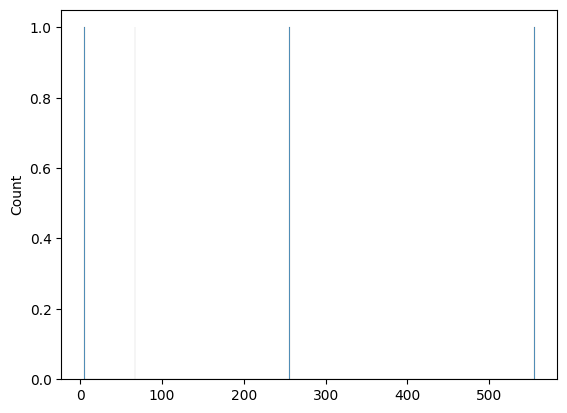

In [58]:
sns.histplot([len(c) for c in tag_clusters.values()], discrete=True)

In [59]:
with open(f"tag_clusters_{VERSION}.json", "w") as fout:
    print(json.dumps(tag_clusters, indent=2, sort_keys=True), file=fout)

In [60]:
LOOKUP_DF

,id,db,country,title,text,embedding
0,5019,sm,GIN,The power of faith facing of the weakness of t...,The power of faith facing of the weakness of t...,"[-0.03254999965429306, -0.4044889807701111, 0...."
1,5164,sm,GIN,local three lines power agregetor,local three lines power agregetor\nDIALLO Thie...,"[-0.0732727125287056, -0.43416595458984375, 0...."
2,5022,sm,GIN,Teflon REGULATOR,Teflon REGULATOR\nThe TEFLON or PTFE is stable...,"[-0.09812592715024948, -0.25181931257247925, -..."
3,2783,sm,GIN,Public Lights auto managed,Public Lights auto managed \nSolution developp...,"[-0.0893172100186348, -0.425068199634552, 0.16..."
4,5021,sm,GIN,ORGANIC WASTE Matanizer !,ORGANIC WASTE Matanizer !\nHere is a Solide wa...,"[-0.095884770154953, -0.19237294793128967, -0...."
...,...,...,...,...,...,...
4248,197,exp,LBY,Reducing the Use of Single-Use Plastic Bags in...,Reducing the Use of Single-Use Plastic Bags in...,"[-0.055976662784814835, -0.4443334937095642, 0..."
4249,362,exp,GTM,Using DPPD to identify greater indigenous poli...,Using DPPD to identify greater indigenous poli...,"[-0.09873020648956299, -0.46956491470336914, 0..."
4250,252,exp,PHL,"Local Convergence: Promoting Agile, Adaptive, ...","Local Convergence: Promoting Agile, Adaptive, ...","[-0.09767404943704605, -0.4477657675743103, 0...."
4251,241,exp,PHL,Marine Litter: Behavioral Insights Experiment ...,Marine Litter: Behavioral Insights Experiment ...,"[-0.08430641144514084, -0.4758320450782776, 0...."


In [61]:
def compute_doc_matrix(db: str) -> np.ndarray:
    df = LOOKUP_DF[LOOKUP_DF["db"] == db]
    res = np.zeros((df.shape[0], df.shape[0]))
    with tqdm(desc=db, total=df.shape[0] * df.shape[0]) as progress_bar:
        for rix in range(df.shape[0]):
            row = df.iloc[rix]
            for cix in range(df.shape[0]):
                progress_bar.update(1)
                if cix > rix:
                    continue
                col = df.iloc[cix]
                dist = get_distances(
                    np.array(row["embedding"]).ravel().reshape((1, -1)),
                    np.array(col["embedding"]))[0]
                res[rix, cix] = dist
                res[cix, rix] = dist
    return res, df["text"].astype(str)

def compute_doc_linkage(doc_matrix):
    return hc.linkage(sp.distance.squareform(doc_matrix.round(10)), method="average")

def get_doc_clusters(doc_linkage, prompts, *, th):
    cids = hc.fcluster(doc_linkage, th, criterion="distance")
    res = collections.defaultdict(list)
    for prompt, cid in zip(prompts, cids):
        res[int(cid)].append(f"{prompt}")
    return dict(res)

def get_doc_clusters_from_db(db: str, th: float) -> dict[int, str]:
    doc_matrix, doc_prompts = compute_doc_matrix(db)
    doc_linkage = compute_doc_linkage(doc_matrix)
    return get_doc_clusters(doc_linkage, doc_prompts, th=th)

In [62]:
sm_doc_matrix, sm_doc_prompts = compute_doc_matrix("sm")
sm_doc_matrix

sm:   0%|          | 0/10169721 [00:00<?, ?it/s]

array([[ 0.00000000e+00,  5.20691425e-03,  2.83599533e-02, ...,
         3.44341437e-03,  8.03540306e-03,  2.05842508e-02],
       [ 5.20691425e-03, -2.22044605e-16,  4.46830922e-02, ...,
         3.05297061e-03,  1.01347947e-02,  3.20484088e-02],
       [ 2.83599533e-02,  4.46830922e-02,  0.00000000e+00, ...,
         4.47855184e-02,  3.79811026e-02,  6.80450041e-03],
       ...,
       [ 3.44341437e-03,  3.05297061e-03,  4.47855184e-02, ...,
         0.00000000e+00,  1.08093982e-02,  3.32426703e-02],
       [ 8.03540306e-03,  1.01347947e-02,  3.79811026e-02, ...,
         1.08093982e-02, -2.22044605e-16,  2.69742070e-02],
       [ 2.05842508e-02,  3.20484088e-02,  6.80450041e-03, ...,
         3.32426703e-02,  2.69742070e-02,  0.00000000e+00]])

In [63]:
sm_doc_matrix.shape, sm_doc_matrix.round(10)

((3189, 3189),
 array([[ 0.        ,  0.00520691,  0.02835995, ...,  0.00344341,
          0.0080354 ,  0.02058425],
        [ 0.00520691, -0.        ,  0.04468309, ...,  0.00305297,
          0.01013479,  0.03204841],
        [ 0.02835995,  0.04468309,  0.        , ...,  0.04478552,
          0.0379811 ,  0.0068045 ],
        ...,
        [ 0.00344341,  0.00305297,  0.04478552, ...,  0.        ,
          0.0108094 ,  0.03324267],
        [ 0.0080354 ,  0.01013479,  0.0379811 , ...,  0.0108094 ,
         -0.        ,  0.02697421],
        [ 0.02058425,  0.03204841,  0.0068045 , ...,  0.03324267,
          0.02697421,  0.        ]]))

In [64]:
sm_doc_linkage = compute_doc_linkage(sm_doc_matrix)

In [65]:
sm_doc_clusters = get_doc_clusters(sm_doc_linkage, sm_doc_prompts, th=0.03)
len(sm_doc_clusters)

9

<AxesSubplot: ylabel='Count'>

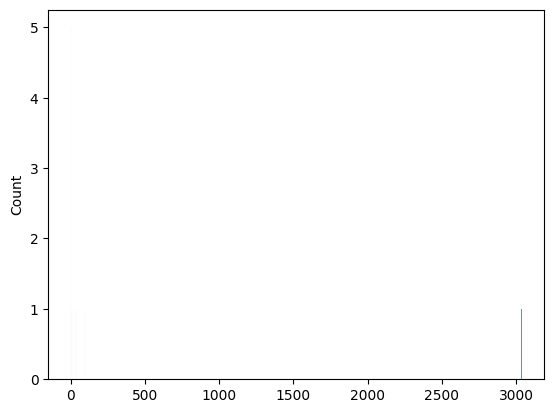

In [66]:
sns.histplot([len(c) for c in sm_doc_clusters.values()], discrete=True)

In [67]:
with open(f"sm_doc_clusters_{VERSION}.json", "w") as fout:
    print(json.dumps(sm_doc_clusters, indent=2, sort_keys=True), file=fout)

ap:   0%|          | 0/743044 [00:00<?, ?it/s]

<AxesSubplot: ylabel='Count'>

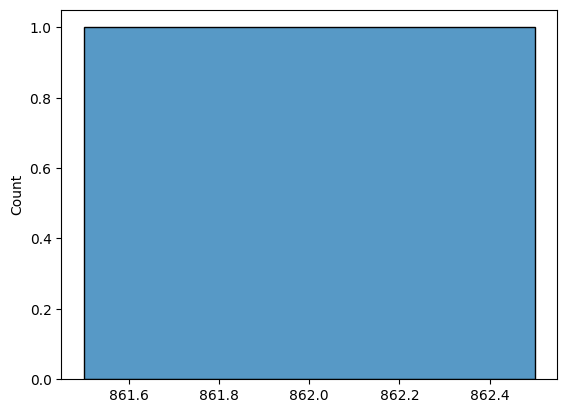

In [68]:
ap_doc_clusters = get_doc_clusters_from_db("ap", 0.03)
sns.histplot([len(c) for c in ap_doc_clusters.values()], discrete=True)

In [69]:
len(ap_doc_clusters)

1

In [70]:
with open(f"ap_doc_clusters_{VERSION}.json", "w") as fout:
    print(json.dumps(ap_doc_clusters, indent=2, sort_keys=True), file=fout)

<AxesSubplot: ylabel='Count'>

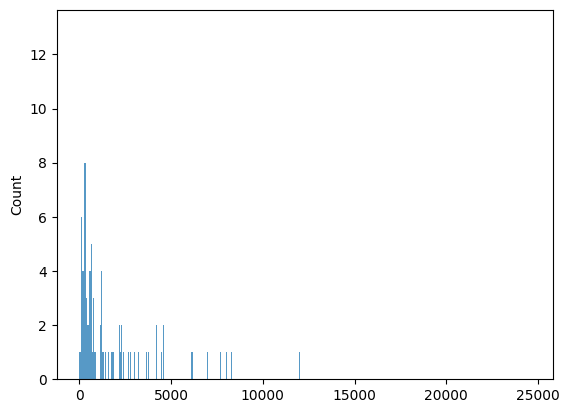

In [71]:
sns.histplot([len(clean(txt)) for txt in LOOKUP_DF["text"]], discrete=True)

In [72]:
ix = np.argmax([len(clean(txt)) for txt in LOOKUP_DF["text"]])
ix, DF.iloc[ix], len(LOOKUP_DF.iloc[ix]["text"])

(3682,
 stage                                                                validation
 id                                                                          274
 db                                                                           ap
 country                                                                     PAN
 title                         ´SWM 3.0 - Exploring the micro-worlds of Tonos...
                                                     ...                        
 tag_youth activism                                                        False
 tag_youth and unemployment                                                False
 tag_youth empowerment                                                     False
 tag_youth informality                                                     False
 tag_zero waste                                                            False
 Name: 3682, Length: 889, dtype: object,
 24578)